# Miscellaneous tasks and quick visualizations
This notebook is a scratchpad for simple utilities, quick checks, and small visualizations used during analysis.

## Aggregate genomic signature matrices (Hallmarks)
Merge multiple per-cohort Hallmark signature matrices (samples × 50 signatures) into a single matrix.
- Ensures signature names match across inputs
- Reorders columns to a canonical order if needed
- Optionally fills missing signatures with NaN and drops unexpected extras (with a warning)
- Outputs a combined CSV with all samples stacked

In [5]:
# Imports and path handling
import os
import pandas as pd
import numpy as np
from typing import List

# --- Robust project root resolver ---
def looks_like_repo_root(path: str) -> bool:
    # Must have 'data' folder and either a git repo or top-level project dirs
    if not os.path.isdir(os.path.join(path, 'data')):
        return False
    if os.path.isdir(os.path.join(path, '.git')):
        return True
    # Heuristics for this project layout
    if os.path.isdir(os.path.join(path, 'Data_Analysis')) and os.path.isdir(os.path.join(path, 'Radiomics')):
        return True
    if os.path.isdir(os.path.join(path, 'data', 'rawdata')):
        return True
    return False

def find_project_root(start: str | None = None, max_up: int = 8) -> str:
    """Walk upwards to find the repo root; prioritize folders that look like the
    top-level project (data + rawdata/.git + key dirs). Fallback to cwd.
    """
    here = os.path.abspath(start or os.getcwd())
    candidate = None
    for _ in range(max_up + 1):
        if looks_like_repo_root(here):
            return here
        # Remember the highest dir that at least has 'data'
        if os.path.isdir(os.path.join(here, 'data')):
            candidate = here
        parent = os.path.dirname(here)
        if parent == here:
            break
        here = parent
    return candidate or os.path.abspath(os.getcwd())

ROOT = find_project_root()
print('Using project root:', ROOT)

# Default inputs (relative to repo root by default)
inputs_rel: List[str] = [
    'data/procdata/gene_signatures/CCRCC_hallmark_signatures.csv',
    'data/procdata/gene_signatures/PDA_hallmark_signatures.csv',
    'data/procdata/gene_signatures/KIRC_hallmark_signatures.csv',
    'data/procdata/gene_signatures/NSCLC_hallmark_signatures.csv',
    'data/procdata/gene_signatures/HNSCC_hallmark_signatures.csv',
]

# Resolve to absolute paths
inputs: List[str] = [p if os.path.isabs(p) else os.path.join(ROOT, p) for p in inputs_rel]

output_dir = os.path.join(ROOT, 'data/procdata/gene_signatures/combined')
output_csv = os.path.join(output_dir, 'hallmarks_all_cohorts_combined.csv')
os.makedirs(output_dir, exist_ok=True)

# Imputation settings for missing signature columns per dataset
impute_strategy = 'median'  # 'median' (default) or 'mean'

def read_signature_matrix(path: str) -> pd.DataFrame:
    df = pd.read_csv(path, index_col=0)
    # Coerce to numeric; keep index as samples
    df = df.apply(pd.to_numeric, errors='coerce')
    # Drop all-NaN rows/cols defensively
    df = df.dropna(axis=0, how='all').dropna(axis=1, how='all')
    return df

# Read all
raw_dfs: List[pd.DataFrame] = []
for p in inputs:
    if not os.path.exists(p):
        raise FileNotFoundError(f'Input not found: {p}')
    raw_dfs.append(read_signature_matrix(p))
if not raw_dfs:
    raise RuntimeError('No input signature matrices provided.')

# Determine union and intersection of signature columns
from collections import Counter
col_counts: Counter = Counter()
for df in raw_dfs:
    col_counts.update(df.columns.tolist())
n_files = len(raw_dfs)
intersection_set = {c for c, k in col_counts.items() if k == n_files}
union_set = set(col_counts.keys())

# Column ordering:
# 1) keep intersection in the order of the first file
# 2) append non-universal (union - intersection) in first-seen order across files
first_order = [c for c in raw_dfs[0].columns if c in intersection_set]
extras_seen = set()
extras_order: List[str] = []
for df in raw_dfs:
    for c in df.columns:
        if c not in intersection_set and c not in extras_seen:
            extras_seen.add(c)
            extras_order.append(c)
combined_cols = first_order + [c for c in extras_order if c not in first_order]

print(f'Common signatures across all datasets: {len(first_order)}')
print(f'Appended cohort-specific signatures: {len(combined_cols) - len(first_order)}')
if len(combined_cols) < 50:
    print('[warn] Total signatures < 50; check inputs. total=', len(combined_cols))

# Prepare per-signature imputation values using all available data across cohorts
impute_values = {}  # signature -> scalar fill value
for c in combined_cols:
    vals = []
    for df in raw_dfs:
        if c in df.columns:
            col = pd.to_numeric(df[c], errors='coerce').dropna().values
            if col.size:
                vals.append(col)
    if vals:
        all_vals = np.concatenate(vals)
        if impute_strategy == 'mean':
            fill = float(np.nanmean(all_vals))
        else:
            fill = float(np.nanmedian(all_vals))
    else:
        # Shouldn't happen because c came from union across inputs, but keep a safe default
        fill = 0.0
    impute_values[c] = fill
print(f"Prepared imputation values for {len(impute_values)} signatures (strategy={impute_strategy}).")

# Align each dataframe to combined_cols, imputing missing signature columns
aligned: List[pd.DataFrame] = []
for i, (p, df) in enumerate(zip(inputs, raw_dfs), start=1):
    # Ensure all columns exist; impute missing with global per-signature value
    missing_cols = [c for c in combined_cols if c not in df.columns]
    if missing_cols:
        for m in missing_cols:
            df[m] = impute_values[m]
        print(f'[{i}/{n_files}] Added {len(missing_cols)} missing signatures imputed ({impute_strategy}) for {os.path.basename(p)}')
    # Reorder
    df = df.reindex(columns=combined_cols)
    aligned.append(df)
    print(f'[{i}/{n_files}] {p}: shape after align ->', df.shape)

# Concatenate all samples row-wise
combined = pd.concat(aligned, axis=0, sort=False)
print('Final combined shape:', combined.shape)

# Save
combined.to_csv(output_csv)
print('Wrote:', output_csv)

Using project root: /Users/jackie-mac/Desktop/VSCode/projects/Radiogenomics
Common signatures across all datasets: 49
Appended cohort-specific signatures: 1
Prepared imputation values for 50 signatures (strategy=median).
[1/5] Added 1 missing signatures imputed (median) for CCRCC_hallmark_signatures.csv
[1/5] /Users/jackie-mac/Desktop/VSCode/projects/Radiogenomics/data/procdata/gene_signatures/CCRCC_hallmark_signatures.csv: shape after align -> (27, 50)
[2/5] /Users/jackie-mac/Desktop/VSCode/projects/Radiogenomics/data/procdata/gene_signatures/PDA_hallmark_signatures.csv: shape after align -> (30, 50)
[3/5] /Users/jackie-mac/Desktop/VSCode/projects/Radiogenomics/data/procdata/gene_signatures/KIRC_hallmark_signatures.csv: shape after align -> (200, 50)
[4/5] /Users/jackie-mac/Desktop/VSCode/projects/Radiogenomics/data/procdata/gene_signatures/NSCLC_hallmark_signatures.csv: shape after align -> (117, 50)
[5/5] /Users/jackie-mac/Desktop/VSCode/projects/Radiogenomics/data/procdata/gene_sig

### Combined Hallmark signature UMAP (dataset-colored)
This cell runs a 2D UMAP embedding on the previously aggregated Hallmark signature matrix, coloring each sample by the dataset/file it originated from. It:
- Loads the combined signatures CSV produced earlier
- Standardizes features (optional)
- Infers dataset labels by matching original input matrices
- Computes UMAP (n_neighbors / min_dist tunable)
- Saves a PNG plot and CSV of coordinates with dataset labels
Use this to visually assess cross-dataset mixing or separation.


In [9]:
# UMAP (2D) on combined matrix, colored by input dataset
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Reuse ROOT, inputs, output paths from previous cell
plots_dir = os.path.join(ROOT, 'data/procdata/gene_signatures/combined/plots')
os.makedirs(plots_dir, exist_ok=True)
name = 'umap_combined_by_inputs'
scale = True
random_state = 10
n_neighbors = 15
min_dist = 0.2
metric = 'euclidean'
point_size = 12
alpha = 0.9

# Load combined matrix (produced by previous cell)
M = pd.read_csv(output_csv, index_col=0)
X = M.apply(pd.to_numeric, errors='coerce').dropna(axis=1, how='all').values
if scale:
    X = StandardScaler().fit_transform(X)

# Build dataset labels from the same inputs used to aggregate
labels = pd.Series('Unknown', index=M.index, dtype='object')
dataset_order = []
for p in inputs:
    ds_name = os.path.basename(p).split('_')[0]  # e.g., CCRCC_hallmark_signatures.csv -> CCRCC
    dataset_order.append(ds_name)
    try:
        df_src = pd.read_csv(p, index_col=0)
        common = labels.index.intersection(df_src.index)
        labels.loc[common] = ds_name
    except Exception as e:
        print(f"[warn] Failed reading {p}: {e}")
print('Label counts:\n', labels.value_counts())

# UMAP embedding
try:
    import umap
except Exception as e:
    raise ImportError("UMAP not available. Install with 'pip install umap-learn'.") from e

um = umap.UMAP(
    n_neighbors=int(n_neighbors),
    min_dist=float(min_dist),
    metric=metric,
    random_state=int(random_state),
    n_components=2,
)
Z = um.fit_transform(X)

# Colors per dataset (dynamic palette)
import seaborn as sns
unique_labels = list(pd.Index(labels.unique()))
palette_colors = sns.color_palette('tab10', n_colors=len(unique_labels))
palette = {ds: palette_colors[i] for i, ds in enumerate(unique_labels)}

# Plot by dataset
plt.figure(figsize=(7.5, 6), dpi=150)
for ds in unique_labels:
    mask = (labels == ds).values
    plt.scatter(Z[mask, 0], Z[mask, 1], s=point_size, alpha=alpha, c=[palette[ds]], label=ds)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('UMAP of Combined Hallmark Signatures by Input Dataset')
plt.grid(alpha=0.2)
plt.legend(title='Dataset', frameon=True, fontsize=9)
plt.tight_layout()
fig_path = os.path.join(plots_dir, f"{name}.png")
plt.savefig(fig_path)
plt.close()

# Save coordinates with labels
coords = pd.DataFrame({'x': Z[:,0], 'y': Z[:,1], 'dataset': labels.values}, index=M.index)
coords_path = os.path.join(plots_dir, f"{name}.csv")
coords.to_csv(coords_path)

print('Wrote plot:', fig_path)
print('Wrote coords:', coords_path)

Label counts:
 KIRC     200
NSCLC    117
HNSCC     57
PDA       30
CCRCC     27
Name: count, dtype: int64


/Users/jackie-mac/Desktop/VSCode/projects/Radiogenomics/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Wrote plot: /Users/jackie-mac/Desktop/VSCode/projects/Radiogenomics/data/procdata/gene_signatures/combined/plots/umap_combined_by_inputs.png
Wrote coords: /Users/jackie-mac/Desktop/VSCode/projects/Radiogenomics/data/procdata/gene_signatures/combined/plots/umap_combined_by_inputs.csv


### Combined Hallmark signature PCA (dataset-colored)
Performs a 2D PCA on the aggregated Hallmark signature matrix, coloring points by originating dataset. It:
- Loads the combined matrix
- Standardizes (optional)
- Builds dataset labels from source files
- Computes PCA (2 components)
- Annotates % variance explained
- Writes plot and coordinates (x,y,dataset)
Use to compare variance-driven separation vs. UMAP's nonlinear structure.


In [10]:
# PCA (2D) on combined matrix, colored by input dataset
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Reuse ROOT, inputs, output paths from previous cells
plots_dir = os.path.join(ROOT, 'data/procdata/gene_signatures/combined/plots')
os.makedirs(plots_dir, exist_ok=True)
name = 'pca_combined_by_inputs'
scale = True
random_state = 10
point_size = 12
alpha = 0.9

# Load combined matrix (produced by aggregation cell)
M = pd.read_csv(output_csv, index_col=0)
X = M.apply(pd.to_numeric, errors='coerce').dropna(axis=1, how='all').values
if scale:
    X = StandardScaler().fit_transform(X)

# Build dataset labels from the same inputs used to aggregate
labels = pd.Series('Unknown', index=M.index, dtype='object')
for p in inputs:
    ds_name = os.path.basename(p).split('_')[0]  # e.g., CCRCC_hallmark_signatures.csv -> CCRCC
    try:
        df_src = pd.read_csv(p, index_col=0)
        common = labels.index.intersection(df_src.index)
        labels.loc[common] = ds_name
    except Exception as e:
        print(f"[warn] Failed reading {p}: {e}")
print('Label counts:\n', labels.value_counts())

# PCA embedding
pca2 = PCA(n_components=2, random_state=random_state)
Z2 = pca2.fit_transform(X)
exp2 = pca2.explained_variance_ratio_

# Colors per dataset (dynamic palette)
import seaborn as sns
unique_labels = list(pd.Index(labels.unique()))
palette_colors = sns.color_palette('tab10', n_colors=len(unique_labels))
palette = {ds: palette_colors[i] for i, ds in enumerate(unique_labels)}

# Plot by dataset
plt.figure(figsize=(7.5, 6), dpi=150)
for ds in unique_labels:
    mask = (labels == ds).values
    plt.scatter(Z2[mask, 0], Z2[mask, 1], s=point_size, alpha=alpha, c=[palette[ds]], label=ds)
plt.xlabel(f"PC1 ({exp2[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({exp2[1]*100:.1f}% var)")
plt.title('PCA of Combined Hallmark Signatures by Input Dataset')
plt.grid(alpha=0.2)
plt.legend(title='Dataset', frameon=True, fontsize=9)
plt.tight_layout()
fig_path = os.path.join(plots_dir, f"{name}.png")
plt.savefig(fig_path)
plt.close()

# Save coordinates with labels
coords = pd.DataFrame({'x': Z2[:,0], 'y': Z2[:,1], 'dataset': labels.values}, index=M.index)
coords_path = os.path.join(plots_dir, f"{name}.csv")
coords.to_csv(coords_path)

print('Wrote plot:', fig_path)
print('Wrote coords:', coords_path)

Label counts:
 KIRC     200
NSCLC    117
HNSCC     57
PDA       30
CCRCC     27
Name: count, dtype: int64
Wrote plot: /Users/jackie-mac/Desktop/VSCode/projects/Radiogenomics/data/procdata/gene_signatures/combined/plots/pca_combined_by_inputs.png
Wrote coords: /Users/jackie-mac/Desktop/VSCode/projects/Radiogenomics/data/procdata/gene_signatures/combined/plots/pca_combined_by_inputs.csv


### Generic PCA kernel (parameterized)
Reusable PCA visualization for any matrix (samples × features). Parameters at top control:
- Input CSV path
- Scaling, random seed
- 2D vs optional 3D scatter
Outputs PNG(s) + coordinate CSV(s). Adapt `input_csv` and `name` to quickly explore new matrices.


## Visualization Kernels

Below are parameterized cells to generate PCA, t-SNE, UMAP, and heatmaps from a single matrix (rows = samples, columns = features/signatures).

In [ ]:
# PCA (2D/optional 3D) scatter

# Parameters
input_csv = 'data/procdata/gene_signatures/NSCLC_hallmark_signatures.csv'  # path to matrix CSV (samples x features)
outdir = 'data/procdata/gene_signatures/combined/plots'
name = 'example_pca'
scale = True              # standardize features (recommended)
random_state = 10
pca_3d = False            # set True to also create a 3D scatter
point_size = 12
alpha = 0.9

# --- Code ---
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

os.makedirs(outdir, exist_ok=True)

# Load matrix (samples as rows)
df = pd.read_csv(input_csv, index_col=0)
# Coerce to numeric and drop all-NaN columns
X = df.apply(pd.to_numeric, errors='coerce').dropna(axis=1, how='all').values
if scale:
    X = StandardScaler().fit_transform(X)

# PCA 2D
pca2 = PCA(n_components=2, random_state=random_state)
Z2 = pca2.fit_transform(X)
exp2 = pca2.explained_variance_ratio_

plt.figure(figsize=(6,5), dpi=150)
plt.scatter(Z2[:,0], Z2[:,1], s=point_size, alpha=alpha)
plt.xlabel(f"PC1 ({exp2[0]*100:.2f}% var)")
plt.ylabel(f"PC2 ({exp2[1]*100:.2f}% var)")
plt.title("PCA (2D)")
plt.grid(alpha=0.2)
plt.tight_layout()
plt.savefig(os.path.join(outdir, f"{name}_pca_2d.png"))
plt.close()

# Save coordinates CSV
pd.DataFrame({'x': Z2[:,0], 'y': Z2[:,1]}, index=df.index).to_csv(os.path.join(outdir, f"{name}_pca_2d.csv"))

# Optional 3D
if pca_3d and X.shape[1] >= 3:
    pca3 = PCA(n_components=3, random_state=random_state)
    Z3 = pca3.fit_transform(X)
    from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
    fig = plt.figure(figsize=(6,5), dpi=150)
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(Z3[:,0], Z3[:,1], Z3[:,2], s=point_size, alpha=alpha)
    exp3 = pca3.explained_variance_ratio_
    ax.set_xlabel(f"PC1 ({exp3[0]*100:.2f}% var)")
    ax.set_ylabel(f"PC2 ({exp3[1]*100:.2f}% var)")
    ax.set_zlabel(f"PC3 ({exp3[2]*100:.2f}% var)")
    ax.set_title("PCA (3D)")
    fig.tight_layout()
    fig.savefig(os.path.join(outdir, f"{name}_pca_3d.png"))
    plt.close(fig)
    pd.DataFrame({'x': Z3[:,0], 'y': Z3[:,1], 'z': Z3[:,2]}, index=df.index).to_csv(os.path.join(outdir, f"{name}_pca_3d.csv"))


### Generic t-SNE kernel (parameterized)
Runs a 2D t-SNE embedding. Parameters let you tune perplexity, iterations, learning rate, scaling. Automatically adjusts perplexity if too large for sample count. Use when exploring local nonlinear structure or potential cluster manifolds.


In [ ]:
# t-SNE (2D) scatter

# Parameters
input_csv = 'data/procdata/gene_signatures/NSCLC_hallmark_signatures.csv'  # path to matrix CSV (samples x features)
outdir = 'data/procdata/gene_signatures/combined/plots'
name = 'example_tsne'
scale = True
random_state = 10
perplexity = 45.0          # will be adjusted down if >= n_samples
n_iter = 1000
learning_rate = 200.0
point_size = 12
alpha = 0.9

# --- Code ---
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

os.makedirs(outdir, exist_ok=True)

df = pd.read_csv(input_csv, index_col=0)
X = df.apply(pd.to_numeric, errors='coerce').dropna(axis=1, how='all').values
if scale:
    X = StandardScaler().fit_transform(X)

n_obs = X.shape[0]
if perplexity >= n_obs:
    new_perp = max(5.0, min(50.0, float(n_obs // 3)))
    print(f"Note: lowering t-SNE perplexity from {perplexity} to {new_perp} for n={n_obs}")
    perplexity = new_perp

tsne = TSNE(
    n_components=2,
    perplexity=perplexity,
    n_iter=n_iter,
    learning_rate=learning_rate,
    random_state=random_state,
    init='pca',
)
Z = tsne.fit_transform(X)

plt.figure(figsize=(6,5), dpi=150)
plt.scatter(Z[:,0], Z[:,1], s=point_size, alpha=alpha)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE (2D)')
plt.grid(alpha=0.2)
plt.tight_layout()
plt.savefig(os.path.join(outdir, f"{name}_tsne_2d.png"))
plt.close()

pd.DataFrame({'x': Z[:,0], 'y': Z[:,1]}, index=df.index).to_csv(os.path.join(outdir, f"{name}_tsne_2d.csv"))


### Generic UMAP kernel (parameterized)
Produces a 2D UMAP embedding; tweak neighbors, min_dist, metric for different resolutions of structure. Useful for capturing global + local relationships compared to t-SNE. Saves plot & coordinates.


In [ ]:
# UMAP (2D) scatter

# Parameters
input_csv = 'data/procdata/gene_signatures/NSCLC_hallmark_signatures.csv'  # path to matrix CSV (samples x features)
outdir = 'data/procdata/gene_signatures/combined/plots'
name = 'example_umap'
scale = True
random_state = 10
n_neighbors = 15
min_dist = 0.1
metric = 'euclidean'
point_size = 12
alpha = 0.9

# --- Code ---
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

os.makedirs(outdir, exist_ok=True)

try:
    import umap
except Exception as e:
    raise ImportError("UMAP not available. Install with 'pip install umap-learn'.") from e


df = pd.read_csv(input_csv, index_col=0)
X = df.apply(pd.to_numeric, errors='coerce').dropna(axis=1, how='all').values
if scale:
    X = StandardScaler().fit_transform(X)

um = umap.UMAP(
    n_neighbors=int(n_neighbors),
    min_dist=float(min_dist),
    metric=metric,
    random_state=int(random_state),
    n_components=2,
)
Z = um.fit_transform(X)

plt.figure(figsize=(6,5), dpi=150)
plt.scatter(Z[:,0], Z[:,1], s=point_size, alpha=alpha)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('UMAP (2D)')
plt.grid(alpha=0.2)
plt.tight_layout()
plt.savefig(os.path.join(outdir, f"{name}_umap_2d.png"))
plt.close()

pd.DataFrame({'x': Z[:,0], 'y': Z[:,1]}, index=df.index).to_csv(os.path.join(outdir, f"{name}_umap_2d.csv"))


### Generic heatmap / clustermap kernel
Generates a heatmap or hierarchical clustered heatmap of a matrix. Parameters select:
- Clustering mode (rows, cols, both, none)
- Color map, centering, value range
Use for quick visual inspection of feature patterns, sample grouping, and outliers.


In [ ]:
# Heatmap / Clustermap

# Parameters
input_csv = 'data/procdata/gene_signatures/NSCLC_hallmark_signatures.csv'  # path to matrix CSV (samples x features)
outdir = 'data/procdata/gene_signatures/combined/plots'
name = 'example_heatmap'
cluster_mode = 'both'      # 'both' | 'rows' | 'cols' | 'none'
cmap = 'vlag'
center = 0.0               # or None to disable centering
vmin = -2.0                # set None to auto
vmax = 2.0                 # set None to auto
figsize = (10, 8)
dpi = 150

# --- Code ---
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

os.makedirs(outdir, exist_ok=True)

df = pd.read_csv(input_csv, index_col=0)
M = df.apply(pd.to_numeric, errors='coerce').dropna(axis=1, how='all')

png_path = os.path.join(outdir, f"{name}_heatmap.png")

if cluster_mode == 'none':
    plt.figure(figsize=figsize, dpi=dpi)
    sns.heatmap(M, cmap=cmap, center=center, vmin=vmin, vmax=vmax)
    plt.title('Heatmap')
    plt.tight_layout()
    plt.savefig(png_path)
    plt.close()
else:
    row_cluster = cluster_mode in ('both', 'rows')
    col_cluster = cluster_mode in ('both', 'cols')
    g = sns.clustermap(M, cmap=cmap, center=center, vmin=vmin, vmax=vmax,
                       row_cluster=row_cluster, col_cluster=col_cluster,
                       figsize=figsize)
    g.fig.suptitle('Clustermap', y=1.02)
    plt.savefig(png_path, dpi=dpi, bbox_inches='tight')
    plt.close()

print('Wrote:', png_path)


### Cohort-colored UMAP on combined Hallmark matrix
Runs UMAP on the already combined Hallmark signatures but colors points by cohort (cancer type) instead of source file. Useful for validating cross-cohort integration and identifying disease-specific signature patterns.


In [ ]:
# UMAP (2D) on combined matrix, colored by dataset

# Parameters
input_csv = 'data/procdata/gene_signatures/combined/hallmarks_all_cohorts_combined.csv'
cohort_sources = {
    'CCRCC': 'data/procdata/gene_signatures/CCRCC_hallmark_signatures.csv',
    'PDA':   'data/procdata/gene_signatures/PDA_hallmark_signatures.csv',
    'KIRC':  'data/procdata/gene_signatures/KIRC_hallmark_signatures.csv',
    'NSCLC': 'data/procdata/gene_signatures/NSCLC_hallmark_signatures.csv',
    'HNSCC': 'data/procdata/gene_signatures/HNSCC_hallmark_signatures.csv',
}
outdir = 'data/procdata/gene_signatures/combined/plots'
name = 'umap_combined_by_cohort'
scale = True
random_state = 10
n_neighbors = 30
min_dist = 0.2
metric = 'euclidean'
point_size = 16
alpha = 0.9

# --- Code ---
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Find repo root (reuse heuristic similar to above)
def _looks_like_root(path: str) -> bool:
    if not os.path.isdir(os.path.join(path, 'data')):
        return False
    if os.path.isdir(os.path.join(path, '.git')):
        return True
    if os.path.isdir(os.path.join(path, 'Data_Analysis')) and os.path.isdir(os.path.join(path, 'Radiomics')):
        return True
    if os.path.isdir(os.path.join(path, 'data', 'rawdata')):
        return True
    return False

def _find_root(start: str | None = None, max_up: int = 8) -> str:
    here = os.path.abspath(start or os.getcwd())
    candidate = None
    for _ in range(max_up + 1):
        if _looks_like_root(here):
            return here
        if os.path.isdir(os.path.join(here, 'data')):
            candidate = here
        parent = os.path.dirname(here)
        if parent == here:
            break
        here = parent
    return candidate or os.path.abspath(os.getcwd())

ROOT = _find_root()
print('Using project root:', ROOT)

# Resolve paths
input_csv_abs = input_csv if os.path.isabs(input_csv) else os.path.join(ROOT, input_csv)
cohort_paths = {k: (v if os.path.isabs(v) else os.path.join(ROOT, v)) for k, v in cohort_sources.items()}
os.makedirs(os.path.join(ROOT, outdir), exist_ok=True)

# Load combined matrix
M = pd.read_csv(input_csv_abs, index_col=0)
X = M.apply(pd.to_numeric, errors='coerce').dropna(axis=1, how='all').values
if scale:
    X = StandardScaler().fit_transform(X)

# Build cohort labels by checking membership in each source matrix
labels = pd.Series(index=M.index, dtype='object')
for cohort, path in cohort_paths.items():
    if not os.path.exists(path):
        print(f"[warn] Cohort source not found: {path}")
        continue
    try:
        dfc = pd.read_csv(path, index_col=0)
    except Exception as e:
        print(f"[warn] Failed reading {path}: {e}")
        continue
    common = labels.index.intersection(dfc.index)
    labels.loc[common] = cohort

labels.fillna('Unknown', inplace=True)
print('Label counts:\n', labels.value_counts())

# UMAP
try:
    import umap
except Exception as e:
    raise ImportError("UMAP not available. Install with 'pip install umap-learn'.") from e

um = umap.UMAP(
    n_neighbors=int(n_neighbors),
    min_dist=float(min_dist),
    metric=metric,
    random_state=int(random_state),
    n_components=2,
)
Z = um.fit_transform(X)

# Prepare colors
unique_labels = labels.unique().tolist()
palette = {
    'CCRCC': 'tab:blue',
    'PDA': 'tab:orange',
    'KIRC': 'tab:green',
    'NSCLC': 'tab:red',
    'HNSCC': 'tab:purple',
    'Unknown': '#8c8c8c',
}
colors = [palette.get(lbl, '#333333') for lbl in labels]

# Plot
plt.figure(figsize=(7.5, 6), dpi=150)
for cohort in unique_labels:
    mask = (labels == cohort).values
    plt.scatter(Z[mask, 0], Z[mask, 1], s=point_size, alpha=alpha, c=palette.get(cohort, '#333333'), label=cohort)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('UMAP of Combined Hallmark Signatures by Cohort')
plt.grid(alpha=0.2)
plt.legend(title='Cohort', frameon=True, fontsize=9)
plt.tight_layout()
fig_path = os.path.join(ROOT, outdir, f"{name}.png")
plt.savefig(fig_path)
plt.close()

# Save coordinates with labels
coords = pd.DataFrame({'x': Z[:,0], 'y': Z[:,1], 'cohort': labels.values}, index=M.index)
coords_path = os.path.join(ROOT, outdir, f"{name}.csv")
coords.to_csv(coords_path)

print('Wrote plot:', fig_path)
print('Wrote coords:', coords_path)

### Radiomic FMCIB feature preprocessing & aggregation
Cleans and merges original FMCIB radiomic feature matrices across datasets. Steps:
- Filter rows to original permutation + full region
- Keep only `pred_` feature columns; drop all-NaN features per dataset
- Median-impute remaining NaNs per feature
- Build union (or intersection) of features across datasets
- Optionally fill missing features with NaN to preserve union
- Write per-dataset cleaned files and a combined aggregated feature matrix
Use this before feature selection, clustering, or radiogenomic correlation analyses.


In [1]:
# Radiomic FMCIB feature preprocessing and aggregation
import os
import pandas as pd
import numpy as np

# Parameters (edit these paths to point to the original FMCIB feature matrices)
radiomic_input_paths = [
    'data/procdata/radiomic_features/fmcib/original/fmcib_features_fmcib_CPTAC-CCRCC_index.csv',
    'data/procdata/radiomic_features/fmcib/original/fmcib_features_fmcib_CPTAC-HNSCC_index.csv',
    'data/procdata/radiomic_features/fmcib/original/fmcib_features_fmcib_CPTAC-PDA_index.csv',
    'data/procdata/radiomic_features/fmcib/original/fmcib_features_fmcib_NSCLC-Radiogenomics_index.csv',
    'data/procdata/radiomic_features/fmcib/original/fmcib_features_fmcib_TCGA-KIRC_index.csv',
]
id_col = 'SampleID'
perm_col = 'readii_Permutation'
region_col = 'readii_Region'
feature_prefix = 'pred_'
# Write outputs to the established location used by downstream cells
output_dir = 'data/procdata/radiomic_features/fmcib/original/combined'
combined_name = 'fmcib_original_features_all_datasets.csv'
fill_missing = True   # if True, fill missing features with NaN (preserve union); if False, drop non-common features
save_per_dataset = True  # write cleaned per-dataset matrices
verbose = True

# Resolve project ROOT using earlier logic if available
def _looks_like_root(path: str) -> bool:
    if not os.path.isdir(os.path.join(path, 'data')):
        return False
    if os.path.isdir(os.path.join(path, '.git')):
        return True
    if os.path.isdir(os.path.join(path, 'Data_Analysis')) and os.path.isdir(os.path.join(path, 'Radiomics')):
        return True
    if os.path.isdir(os.path.join(path, 'data', 'rawdata')):
        return True
    return False

def _find_root(start: str | None = None, max_up: int = 8) -> str:
    here = os.path.abspath(start or os.getcwd())
    candidate = None
    for _ in range(max_up + 1):
        if _looks_like_root(here):
            return here
        if os.path.isdir(os.path.join(here, 'data')):
            candidate = here
        parent = os.path.dirname(here)
        if parent == here:
            break
        here = parent
    return candidate or os.path.abspath(os.getcwd())

ROOT = _find_root()
print('Using project root:', ROOT)

# Resolve absolute paths
inputs_abs = [p if os.path.isabs(p) else os.path.join(ROOT, p) for p in radiomic_input_paths]
out_abs_dir = output_dir if os.path.isabs(output_dir) else os.path.join(ROOT, output_dir)
os.makedirs(out_abs_dir, exist_ok=True)


def read_radiomic(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    if id_col not in df.columns or perm_col not in df.columns or region_col not in df.columns:
        raise ValueError(f'Missing required columns in {path}. Need {id_col}, {perm_col}, {region_col}.')
    # Filter rows
    df[perm_col] = df[perm_col].astype(str).str.strip().str.lower()
    df[region_col] = df[region_col].astype(str).str.strip().str.lower()
    sub = df[(df[perm_col] == 'original') & (df[region_col] == 'full')].copy()
    if sub.empty:
        raise ValueError(f'No rows after filtering original/full in {path}')
    # Select feature columns
    feat_cols = [c for c in sub.columns if c.startswith(feature_prefix)]
    if not feat_cols:
        raise ValueError(f'No feature columns starting with {feature_prefix} in {path}')
    keep = [id_col] + feat_cols if id_col in sub.columns else feat_cols
    sub = sub.loc[:, keep]
    # Coerce numeric
    for c in feat_cols:
        sub[c] = pd.to_numeric(sub[c], errors='coerce')
    # Drop completely NaN feature columns
    drop_nan = [c for c in feat_cols if sub[c].isna().all()]
    if drop_nan:
        sub.drop(columns=drop_nan, inplace=True)
        feat_cols = [c for c in feat_cols if c not in drop_nan]
        if verbose:
            print(f'[{os.path.basename(path)}] Dropped {len(drop_nan)} all-NaN features.')
    # Impute remaining NaNs per feature with median (optional improvement)
    for c in feat_cols:
        if sub[c].isna().any():
            med = sub[c].median()
            sub[c].fillna(med, inplace=True)
    return sub, feat_cols

cleaned_dfs = []
feature_sets = []
for i, p in enumerate(inputs_abs, start=1):
    if not os.path.exists(p):
        print(f'[warn] Input file not found: {p}')
        continue
    try:
        df_clean, fcols = read_radiomic(p)
        cleaned_dfs.append(df_clean)
        feature_sets.append(set(fcols))
        if verbose:
            print(f'[{i}/{len(inputs_abs)}] {os.path.basename(p)} -> rows={df_clean.shape[0]}, features={len(fcols)}')
        if save_per_dataset:
            out_clean_path = os.path.join(out_abs_dir, os.path.splitext(os.path.basename(p))[0] + '_cleaned.csv')
            df_clean.to_csv(out_clean_path, index=False)
            if verbose:
                print('   wrote cleaned:', out_clean_path)
    except Exception as e:
        print(f'[error] Failed processing {p}: {e}')

if not cleaned_dfs:
    raise RuntimeError('No radiomic inputs successfully processed. Populate radiomic_input_paths with valid files.')

# Determine union & intersection of feature columns
feat_union = sorted(set.union(*feature_sets)) if feature_sets else []
feat_intersection = sorted(set.intersection(*feature_sets)) if feature_sets else []
print('Feature sets summary:')
print('  datasets processed:', len(cleaned_dfs))
print('  union feature count:', len(feat_union))
print('  intersection feature count:', len(feat_intersection))

# Align each cleaned dataframe to union (or intersection)
target_feats = feat_union if fill_missing else feat_intersection
if not target_feats:
    raise RuntimeError('No target features determined (empty union/intersection).')

aligned = []
for df in cleaned_dfs:
    avail = [c for c in df.columns if c.startswith(feature_prefix)]
    missing = [c for c in target_feats if c not in avail]
    if missing and fill_missing:
        for m in missing:
            df[m] = np.nan
        if verbose:
            print(f'Filled {len(missing)} missing features with NaN for {df[id_col].iloc[0] if id_col in df.columns else "dataset"}.')
    # Reorder
    ordered_cols = [id_col] + target_feats if id_col in df.columns else target_feats
    df_ord = df.reindex(columns=ordered_cols)
    aligned.append(df_ord)

# Concatenate
combined = pd.concat(aligned, axis=0, sort=False)
print('Combined shape:', combined.shape)
combined_out = os.path.join(out_abs_dir, combined_name)
combined.to_csv(combined_out, index=False)
print('Wrote aggregated radiomic feature matrix:', combined_out)

Using project root: /Users/jackie-mac/Desktop/VSCode/projects/Radiogenomics
[1/5] fmcib_features_fmcib_CPTAC-CCRCC_index.csv -> rows=101, features=4096
[1/5] fmcib_features_fmcib_CPTAC-CCRCC_index.csv -> rows=101, features=4096
   wrote cleaned: /Users/jackie-mac/Desktop/VSCode/projects/Radiogenomics/data/procdata/radiomic_features/fmcib/original/combined/fmcib_features_fmcib_CPTAC-CCRCC_index_cleaned.csv
   wrote cleaned: /Users/jackie-mac/Desktop/VSCode/projects/Radiogenomics/data/procdata/radiomic_features/fmcib/original/combined/fmcib_features_fmcib_CPTAC-CCRCC_index_cleaned.csv
[2/5] fmcib_features_fmcib_CPTAC-HNSCC_index.csv -> rows=209, features=4096
[2/5] fmcib_features_fmcib_CPTAC-HNSCC_index.csv -> rows=209, features=4096
   wrote cleaned: /Users/jackie-mac/Desktop/VSCode/projects/Radiogenomics/data/procdata/radiomic_features/fmcib/original/combined/fmcib_features_fmcib_CPTAC-HNSCC_index_cleaned.csv
   wrote cleaned: /Users/jackie-mac/Desktop/VSCode/projects/Radiogenomics/dat

### Radiomics PCA by original dataset
Generates a 2D PCA scatter from the combined FMCIB radiomics matrix, coloring samples by their original dataset (cohort). Labels are inferred by matching `SampleID` to the original per-dataset radiomics files filtered to permutation=`original` and region=`full`. Saves a PNG plot and a CSV of PCA coordinates with dataset labels.

In [3]:
# PCA (2D) on combined radiomics matrix, colored by original dataset

# Parameters
combined_csv = 'data/procdata/radiomic_features/fmcib/original/combined/fmcib_original_features_all_datasets.csv'
# Use CLEANED per-dataset radiomics matrices for label inference
source_files = [
    'data/procdata/radiomic_features/fmcib/original/combined/fmcib_features_fmcib_CPTAC-CCRCC_index_cleaned.csv',
    'data/procdata/radiomic_features/fmcib/original/combined/fmcib_features_fmcib_CPTAC-HNSCC_index_cleaned.csv',
    'data/procdata/radiomic_features/fmcib/original/combined/fmcib_features_fmcib_CPTAC-PDA_index_cleaned.csv',
    'data/procdata/radiomic_features/fmcib/original/combined/fmcib_features_fmcib_NSCLC-Radiogenomics_index_cleaned.csv',
    'data/procdata/radiomic_features/fmcib/original/combined/fmcib_features_fmcib_TCGA-KIRC_index_cleaned.csv',
]
outdir = 'data/procdata/radiomic_features/fmcib/original/combined/plots'
name = 'radiomics_pca_by_dataset'
id_col = 'SampleID'
feature_prefix = 'pred_'
perm_col = 'readii_Permutation'
region_col = 'readii_Region'
perm_value = 'original'
region_value = 'full'
scale = True
random_state = 10
point_size = 14
alpha = 0.9

# --- Code ---
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Find repo root (reuse heuristic similar to other cells)
def _looks_like_root(path: str) -> bool:
    if not os.path.isdir(os.path.join(path, 'data')):
        return False
    if os.path.isdir(os.path.join(path, '.git')):
        return True
    if os.path.isdir(os.path.join(path, 'Data_Analysis')) and os.path.isdir(os.path.join(path, 'Radiomics')):
        return True
    if os.path.isdir(os.path.join(path, 'data', 'rawdata')):
        return True
    return False

def _find_root(start: str | None = None, max_up: int = 8) -> str:
    here = os.path.abspath(start or os.getcwd())
    candidate = None
    for _ in range(max_up + 1):
        if _looks_like_root(here):
            return here
        if os.path.isdir(os.path.join(here, 'data')):
            candidate = here
        parent = os.path.dirname(here)
        if parent == here:
            break
        here = parent
    return candidate or os.path.abspath(os.getcwd())

ROOT = _find_root()
print('Using project root:', ROOT)

# Resolve paths
combined_csv_abs = combined_csv if os.path.isabs(combined_csv) else os.path.join(ROOT, combined_csv)
sources_abs = [p if os.path.isabs(p) else os.path.join(ROOT, p) for p in source_files]
plots_dir = outdir if os.path.isabs(outdir) else os.path.join(ROOT, outdir)
os.makedirs(plots_dir, exist_ok=True)

# Load combined radiomics matrix
if not os.path.exists(combined_csv_abs):
    raise FileNotFoundError(f"Combined CSV not found: {combined_csv_abs}")

comb = pd.read_csv(combined_csv_abs)
if id_col not in comb.columns:
    raise ValueError(f"Combined CSV must contain id column '{id_col}'. Columns head: {comb.columns.tolist()[:10]}")

# Normalize SampleIDs: string + strip for robust matching
comb[id_col] = comb[id_col].astype(str).str.strip()
comb.set_index(id_col, inplace=True)

feat_cols = [c for c in comb.columns if c.startswith(feature_prefix)]
if not feat_cols:
    raise RuntimeError(f"No feature columns starting with '{feature_prefix}' in combined file.")

X = comb.loc[:, feat_cols].apply(pd.to_numeric, errors='coerce')
# Drop all-NaN columns and impute remaining NaNs per-feature with median
X = X.dropna(axis=1, how='all')
X = X.apply(lambda col: col.fillna(col.median()))

if scale:
    X = pd.DataFrame(StandardScaler().fit_transform(X.values), index=X.index, columns=X.columns)

# Label inference: preserve explicit 'NSCLC-Radiogenomics' name if present
def _infer_label_from_filename(basename: str) -> str:
    name = os.path.splitext(basename)[0]
    # Prefer full token if present
    if re.search(r'nsclc[-_ ]?radiogenomics', name, flags=re.IGNORECASE):
        return 'NSCLC-Radiogenomics'
    # Common cohort tokens
    tokens = ['CCRCC', 'HNSCC', 'PDA', 'NSCLC', 'KIRC']
    for t in tokens:
        if re.search(rf"\b{re.escape(t)}\b", name, flags=re.IGNORECASE):
            return t.upper()
    # Try broader matches like 'CPTAC-CCRCC', 'TCGA-KIRC'
    m = re.search(r'(CPTAC|TCGA)-([A-Za-z0-9]+)', name, flags=re.IGNORECASE)
    if m:
        return m.group(2).upper()
    return name

# Build dataset labels by matching SampleID membership in each source file
labels = pd.Series('Unknown', index=X.index, dtype='object')
# Precompute normalized combined IDs for robust comparison
combined_ids_norm = pd.Series(labels.index.astype(str).str.strip(), index=labels.index)

for p in sources_abs:
    if not os.path.exists(p):
        print(f"[warn] Source not found, skipping: {p}")
        continue
    try:
        df_src = pd.read_csv(p)
        if id_col not in df_src.columns:
            print(f"[warn] {os.path.basename(p)} missing '{id_col}', skipping")
            continue
        # Cleaned files may not carry perm/region columns; filter only if present
        if perm_col in df_src.columns:
            df_src[perm_col] = df_src[perm_col].astype(str).str.strip().str.lower()
            df_src = df_src[df_src[perm_col] == perm_value.lower()]
        if region_col in df_src.columns:
            df_src[region_col] = df_src[region_col].astype(str).str.strip().str.lower()
            df_src = df_src[df_src[region_col] == region_value.lower()]
        # Normalize source IDs for robust intersection
        src_ids_norm = pd.Index(df_src[id_col].astype(str).str.strip())
        # Map back to original combined index using normalized equality
        mask = combined_ids_norm.isin(src_ids_norm)
        common = combined_ids_norm.index[mask]
        if len(common) == 0:
            print(f"[info] No overlapping samples for source {os.path.basename(p)}")
            continue
        ds = _infer_label_from_filename(os.path.basename(p))
        labels.loc[common] = ds
        print(f"[label] {ds}: matched {len(common)} samples")
    except Exception as e:
        print(f"[warn] Failed reading {p}: {e}")

print('Label counts:\n', labels.value_counts())

# PCA
pca2 = PCA(n_components=2, random_state=random_state)
Z2 = pca2.fit_transform(X.values)
exp2 = pca2.explained_variance_ratio_

# Colors per dataset
import seaborn as sns
unique_labels = list(pd.Index(labels.unique()))
palette_colors = sns.color_palette('tab10', n_colors=len(unique_labels))
palette = {ds: palette_colors[i] for i, ds in enumerate(unique_labels)}

# Plot
plt.figure(figsize=(8, 6), dpi=150)
for ds in unique_labels:
    mask = (labels == ds).values
    plt.scatter(Z2[mask, 0], Z2[mask, 1], s=point_size, alpha=alpha, c=[palette[ds]], label=ds)
plt.xlabel(f"PC1 ({exp2[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({exp2[1]*100:.1f}% var)")
plt.title('Radiomics PCA by Dataset')
plt.grid(alpha=0.25)
plt.legend(title='Dataset', frameon=True, fontsize=9)
plt.tight_layout()

fig_path = os.path.join(plots_dir, f"{name}.png")
plt.savefig(fig_path)
plt.close()

# Save coordinates with labels
coords = pd.DataFrame({'x': Z2[:, 0], 'y': Z2[:, 1], 'dataset': labels.values}, index=X.index)
coords_path = os.path.join(plots_dir, f"{name}.csv")
coords.to_csv(coords_path)

print('Wrote plot:', fig_path)
print('Wrote coords:', coords_path)


Using project root: /Users/jackie-mac/Desktop/VSCode/projects/Radiogenomics
[label] CCRCC: matched 101 samples
[label] HNSCC: matched 209 samples
[label] PDA: matched 61 samples
[label] NSCLC-Radiogenomics: matched 116 samples
[label] CCRCC: matched 101 samples
[label] HNSCC: matched 209 samples
[label] PDA: matched 61 samples
[label] NSCLC-Radiogenomics: matched 116 samples
[label] KIRC: matched 423 samples
Label counts:
 KIRC                   423
HNSCC                  209
NSCLC-Radiogenomics    116
CCRCC                  101
PDA                     61
Name: count, dtype: int64
Wrote plot: /Users/jackie-mac/Desktop/VSCode/projects/Radiogenomics/data/procdata/radiomic_features/fmcib/original/combined/plots/radiomics_pca_by_dataset.png
Wrote coords: /Users/jackie-mac/Desktop/VSCode/projects/Radiogenomics/data/procdata/radiomic_features/fmcib/original/combined/plots/radiomics_pca_by_dataset.csv
[label] KIRC: matched 423 samples
Label counts:
 KIRC                   423
HNSCC           

In [5]:
# Append numeric cancer_type codes to combined radiomics feature matrix (row-wise matching preserving duplicates)

# Parameters
combined_csv = 'data/procdata/radiomic_features/fmcib/original/combined/fmcib_original_features_all_datasets.csv'
# Cleaned per-dataset source files with assigned codes
source_files_with_codes = [
    (0, 'data/procdata/radiomic_features/fmcib/original/combined/fmcib_features_fmcib_CPTAC-PDA_index_cleaned.csv'),
    (1, 'data/procdata/radiomic_features/fmcib/original/combined/fmcib_features_fmcib_CPTAC-CCRCC_index_cleaned.csv'),
    (2, 'data/procdata/radiomic_features/fmcib/original/combined/fmcib_features_fmcib_CPTAC-HNSCC_index_cleaned.csv'),
    (3, 'data/procdata/radiomic_features/fmcib/original/combined/fmcib_features_fmcib_NSCLC-Radiogenomics_index_cleaned.csv'),
    (4, 'data/procdata/radiomic_features/fmcib/original/combined/fmcib_features_fmcib_TCGA-KIRC_index_cleaned.csv'),
]
id_col = 'SampleID'
output_augmented = 'data/procdata/radiomic_features/fmcib/original/combined/fmcib_original_features_all_datasets_with_cancer_type.csv'

import os
import pandas as pd
import numpy as np

# Reuse ROOT if previously defined, else recompute
try:
    ROOT  # noqa: F821
except NameError:
    def _looks_like_root(path: str) -> bool:
        if not os.path.isdir(os.path.join(path, 'data')):
            return False
        if os.path.isdir(os.path.join(path, '.git')):
            return True
        if os.path.isdir(os.path.join(path, 'Data_Analysis')) and os.path.isdir(os.path.join(path, 'Radiomics')):
            return True
        if os.path.isdir(os.path.join(path, 'data', 'rawdata')):
            return True
        return False
    def _find_root(start: str | None = None, max_up: int = 8) -> str:
        here = os.path.abspath(start or os.getcwd())
        candidate = None
        for _ in range(max_up + 1):
            if _looks_like_root(here):
                return here
            if os.path.isdir(os.path.join(here, 'data')):
                candidate = here
            parent = os.path.dirname(here)
            if parent == here:
                break
            here = parent
        return candidate or os.path.abspath(os.getcwd())
    ROOT = _find_root()
    print('Using project root (recomputed):', ROOT)

combined_csv_abs = combined_csv if os.path.isabs(combined_csv) else os.path.join(ROOT, combined_csv)
if not os.path.exists(combined_csv_abs):
    raise FileNotFoundError(f'Combined radiomics CSV not found: {combined_csv_abs}')

# Load combined matrix (keep duplicate SampleIDs as separate rows)
comb = pd.read_csv(combined_csv_abs)
if id_col not in comb.columns:
    raise ValueError(f"'{id_col}' column missing from combined matrix. Columns head: {comb.columns.tolist()[:15]}")

# Normalize SampleIDs for matching (do NOT drop duplicates)
comb[id_col] = comb[id_col].astype(str).str.strip()

# Prepare cancer_type codes per row
cancer_codes = pd.Series(np.nan, index=comb.index, dtype='float64')  # one entry per row
sample_ids_norm = comb[id_col]  # normalized per row

assigned_counts = {}
conflicts = {}  # row-level conflicts where a different code already present

for code, rel_path in source_files_with_codes:
    path_abs = rel_path if os.path.isabs(rel_path) else os.path.join(ROOT, rel_path)
    if not os.path.exists(path_abs):
        print(f'[warn] Source file missing, skipping: {path_abs}')
        continue
    try:
        df_src = pd.read_csv(path_abs)
    except Exception as e:
        print(f'[warn] Failed reading {path_abs}: {e}')
        continue
    if id_col not in df_src.columns:
        print(f"[warn] '{id_col}' missing in source: {path_abs}; skipping")
        continue
    src_ids_norm = df_src[id_col].astype(str).str.strip()
    # Row-wise membership mask (preserves duplicates)
    mask = sample_ids_norm.isin(src_ids_norm)
    n_match = int(mask.sum())
    if n_match == 0:
        print(f'[info] No overlap for code {code} in {os.path.basename(path_abs)}')
        continue
    # Identify conflicting rows (assigned to different code already)
    already = cancer_codes[mask]
    conflict_rows = already.notna() & (already != code)
    if conflict_rows.any():
        for ridx in cancer_codes[mask].index[conflict_rows]:
            prev_code = int(cancer_codes.loc[ridx])
            conflicts.setdefault(ridx, set()).update([prev_code, int(code)])
    # Assign (overwrite if NaN or same code; retain first if different? We'll still overwrite to last source precedence)
    cancer_codes.loc[mask] = float(code)
    assigned_counts[code] = assigned_counts.get(code, 0) + n_match
    print(f'[assign] code {code}: matched {n_match} rows from {os.path.basename(path_abs)}')

if conflicts:
    print('[conflict] Rows matched multiple different dataset codes; final code reflects last source processed.')
    shown = 0
    for ridx, codes in conflicts.items():
        if shown >= 10:
            print('  ...')
            break
        sid = sample_ids_norm.loc[ridx]
        print(f'  row_index={ridx}, SampleID={sid}, codes_seen={sorted(codes)}')
        shown += 1
    print(f'Total conflicting rows: {len(conflicts)}')
else:
    print('No multi-source row conflicts detected.')

unassigned = int(cancer_codes.isna().sum())
if unassigned:
    print(f'[warn] {unassigned} rows remain unassigned (code NaN).')
else:
    print('All rows assigned a cancer_type code.')

# Cast to int if fully assigned
if unassigned == 0:
    cancer_codes = cancer_codes.astype(int)

# Append column (maintain original row order, duplicates preserved)
comb['cancer_type'] = cancer_codes.values

# Save augmented matrix
output_augmented_abs = output_augmented if os.path.isabs(output_augmented) else os.path.join(ROOT, output_augmented)
os.makedirs(os.path.dirname(output_augmented_abs), exist_ok=True)
comb.to_csv(output_augmented_abs, index=False)
print('Wrote augmented matrix with cancer_type:', output_augmented_abs)

# Summary table
summary_df = pd.DataFrame(
    [{'cancer_type_code': c, 'assigned_row_count': assigned_counts.get(c, 0)} for c, _ in source_files_with_codes]
).set_index('cancer_type_code')
print('Assignment summary (row counts):\n', summary_df)


[assign] code 0: matched 61 rows from fmcib_features_fmcib_CPTAC-PDA_index_cleaned.csv
[assign] code 1: matched 101 rows from fmcib_features_fmcib_CPTAC-CCRCC_index_cleaned.csv
[assign] code 2: matched 209 rows from fmcib_features_fmcib_CPTAC-HNSCC_index_cleaned.csv
[assign] code 3: matched 116 rows from fmcib_features_fmcib_NSCLC-Radiogenomics_index_cleaned.csv
[assign] code 2: matched 209 rows from fmcib_features_fmcib_CPTAC-HNSCC_index_cleaned.csv
[assign] code 3: matched 116 rows from fmcib_features_fmcib_NSCLC-Radiogenomics_index_cleaned.csv
[assign] code 4: matched 423 rows from fmcib_features_fmcib_TCGA-KIRC_index_cleaned.csv
No multi-source row conflicts detected.
All rows assigned a cancer_type code.
[assign] code 4: matched 423 rows from fmcib_features_fmcib_TCGA-KIRC_index_cleaned.csv
No multi-source row conflicts detected.
All rows assigned a cancer_type code.
Wrote augmented matrix with cancer_type: /Users/jackie-mac/Desktop/VSCode/projects/Radiogenomics/data/procdata/radi

## Correlation Heat Maps

In [ ]:
# Correlation heatmap helper
import math
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


def plot_correlation_heatmap_from_csv(
    csv_path,
    out_png=None,
    out_dir=None,
    corr_type="spearman",        # 'spearman' or 'pearson' (affects title/labels only)
    transpose_if_taller=True,
    cmap="Spectral_r",
    cell_w=0.50,
    cell_h=0.35,
    row_spacing_factor=1.2,     # multiply per-row height to increase spacing between rows
    min_fig_w=10,
    min_fig_h=8,
    dpi=300,
    vmax=None,
    vmin=None,
    x_label_size=8,
    y_label_size=8,
    y_label_pad=6,
    cbar_fraction=0.20,   # increased default to make colorbar longer
    cbar_aspect=30,        # larger aspect to lengthen the colorbar
    cbar_pad=0.02,
    cbar_shrink=0.9,  # default shrink to keep colorbar length
    cbar_tick_size=8,
    # clustering options
    cluster_rows=False,
    cluster_cols=True,
    cluster_method='average',
    cluster_metric='euclidean',
    dendrogram_ratio=None,
    show=True,
):
    """Load a correlation matrix CSV and save a heatmap or clustermap PNG.

    Behavior:
    - CSV is read with `index_col=0` by default (row labels in first column).
    - If the matrix is taller than wide (more rows than columns) and
    `transpose_if_taller` is True, the matrix is transposed so that the
    longer side appears on the X axis (making the plot wider).
    - Figure size is adapted so the plot is not visually squished; use
    `row_spacing_factor` to increase spacing between y rows.
    - NaN cells are shown in light grey. If clustering is requested,
    hierarchical clustering is performed using seaborn.clustermap.

    Returns the path to the saved PNG.
    """
    # read CSV; prefer index_col=0 but fall back if that fails
    try:
        df = pd.read_csv(csv_path, index_col=0)
    except Exception:
        df = pd.read_csv(csv_path)
        if df.shape[1] > 1:
            maybe_idx = df.columns[0]
            try:
                df = df.set_index(maybe_idx)
            except Exception:
                pass

    # coerce to numeric values where possible
    df = df.apply(pd.to_numeric, errors="coerce")

    if df.size == 0:
        raise ValueError(f"Empty or non-numeric matrix loaded from {csv_path}")

    # preserve original axis labels
    rows_orig = list(df.index.astype(str))
    cols_orig = list(df.columns.astype(str))

    # transpose if taller than wide to ensure the longer side is along x axis
    transposed = False
    if transpose_if_taller and df.shape[0] > df.shape[1]:
        df = df.T
        transposed = True

    n_rows, n_cols = df.shape

    # choose vmin/vmax for correlations; default to [-1,1] unless data exceeds bounds
    data_min, data_max = np.nanmin(df.values), np.nanmax(df.values)
    default_vmin, default_vmax = -1.0, 1.0
    if vmin is None:
        vmin = min(default_vmin, float(data_min))
    if vmax is None:
        vmax = max(default_vmax, float(data_max))

    # compute figure size, but limit to reasonable bounds
    fig_w = max(min_fig_w, n_cols * cell_w)
    fig_h = max(min_fig_h, n_rows * cell_h * row_spacing_factor)
    # ensure plot is wider than tall
    if fig_w < fig_h:
        fig_w = fig_h + 1.0
    # clamp to avoid extremely large images
    fig_w = min(fig_w, 120)
    fig_h = min(fig_h, 120)

    # prepare colormap and NaN (bad) color
    cmap_obj = mpl.cm.get_cmap(cmap)
    try:
        cmap_obj.set_bad("#d3d3d3")  # light grey for NaN
    except Exception:
        cmap_obj = mpl.colors.ListedColormap(cmap_obj(np.linspace(0, 1, 256)))
        cmap_obj.set_bad("#d3d3d3")

    mask = df.isna()

    # prepare common colorbar settings
    cbar_kws = {
        "fraction": cbar_fraction,
        "pad": cbar_pad,
        "aspect": cbar_aspect,
    }
    if cbar_shrink is not None:
        cbar_kws["shrink"] = cbar_shrink

    # determine output PNG path: `out_png` explicit has precedence, else use `out_dir`+basename, else same-dir with suffix
    if out_png is None:
        base = os.path.splitext(os.path.basename(csv_path))[0]
        default_name = f"{base}_{corr_type.lower()}_heatmap.png"
        if out_dir is not None:
            os.makedirs(out_dir, exist_ok=True)
            out_png = os.path.join(out_dir, default_name)
        else:
            out_png = os.path.join(os.path.dirname(csv_path) or '.', default_name)

    # Plot either a simple heatmap or a clustered heatmap depending on clustering flags
    if not (cluster_rows or cluster_cols):
        plt.figure(figsize=(fig_w, fig_h), dpi=dpi)
        ax = sns.heatmap(
            df,
            cmap=cmap_obj,
            center=0,
            vmin=vmin,
            vmax=vmax,
            mask=mask,
            cbar_kws=cbar_kws,
            linewidths=0,
        )
        # adjust tick label fonts and padding
        try:
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=x_label_size)
        except Exception:
            plt.xticks(rotation=45)
        try:
            ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=y_label_size)
        except Exception:
            plt.yticks(rotation=0)
        ax.tick_params(axis='y', which='major', pad=y_label_pad)
        # format colorbar ticks
        try:
            cbar = ax.collections[0].colorbar
            ticks = np.linspace(vmin, vmax, 9)
            cbar.set_ticks(ticks)
            cbar.set_ticklabels([f"{t:.2f}" for t in ticks])
            cbar.ax.tick_params(labelsize=cbar_tick_size)
        except Exception:
            pass
        title = f"{corr_type.capitalize()} correlation heatmap{' (transposed)' if transposed else ''}"
        plt.title(title)
        plt.tight_layout()
        plt.savefig(out_png, dpi=dpi, bbox_inches='tight')
        try:
            plt.savefig(out_png.replace('.png', '.pdf'), bbox_inches='tight')
        except Exception:
            pass
        if show:
            plt.show()
        plt.close()
    else:
        # Use seaborn.clustermap for hierarchical clustering
        row_cluster = bool(cluster_rows)
        col_cluster = bool(cluster_cols)
        # sensible default dendrogram ratios if not provided (row, col)
        if dendrogram_ratio is None:
            # lower ratio if many columns to leave space for heatmap
            dendrogram_ratio = (0.12, 0.12)
        g = sns.clustermap(
            df,
            cmap=cmap_obj,
            center=0,
            vmin=vmin,
            vmax=vmax,
            mask=mask,
            row_cluster=row_cluster,
            col_cluster=col_cluster,
            method=cluster_method,
            metric=cluster_metric,
            figsize=(fig_w, fig_h),
            cbar_kws=cbar_kws,
            dendrogram_ratio=dendrogram_ratio,
        )
        # improve label fonts
        try:
            for lbl in g.ax_heatmap.get_xticklabels():
                lbl.set_rotation(45)
                lbl.set_ha("right")
                lbl.set_fontsize(x_label_size)
            for lbl in g.ax_heatmap.get_yticklabels():
                lbl.set_rotation(0)
                lbl.set_fontsize(y_label_size)
            g.ax_heatmap.tick_params(axis='y', which='major', pad=y_label_pad)
        except Exception:
            pass
        # format colorbar ticks
        try:
            ticks = np.linspace(vmin, vmax, 9)
            if hasattr(g, 'cax') and g.cax is not None:
                try:
                    g.cax.yaxis.set_ticks(ticks)
                    g.cax.yaxis.set_ticklabels([f"{t:.2f}" for t in ticks])
                    g.cax.yaxis.set_tick_params(labelsize=cbar_tick_size)
                except Exception:
                    pass
        except Exception:
            pass
        # title on top of the clustered figure
        try:
            g.fig.suptitle(f"{corr_type.capitalize()} correlation clustermap{' (All-Signatures)' if transposed else ''}", y=1.02)
        except Exception:
            pass
        # save the clustermap figure
        g.fig.savefig(out_png, dpi=dpi, bbox_inches='tight')

        try:
            g.fig.savefig(out_png.replace('.png', '.pdf'), bbox_inches='tight')
        except Exception:
            pass
        if show:
            plt.show()
        plt.close(g.fig)

    print(f"Wrote: {out_png}")
    return out_png

# Examples:
# simple: plot_correlation_heatmap_from_csv('results/my_corr.csv', out_dir='results/heatmaps')
# clustered rows+cols: plot_correlation_heatmap_from_csv('results/my_corr.csv', out_dir='results/heatmaps', cluster_rows=True, cluster_cols=True)


In [19]:
# Run the heatmap helper on your MULTITASK_LASSO test Spearman CSV
csv_path = "/Users/jackie-mac/Desktop/VSCode/projects/Radiogenomics/data/procdata/radiomic_features/fmcib/features/MULTITASK_LASSO/fmcib_original_features_all_datasets_with_cancer_type__x__hallmarks_all_cohorts_combined_test_spearman_corr.csv"
out_dir = "/Users/jackie-mac/Desktop/VSCode/projects/Radiogenomics/data/procdata/radiomic_features/fmcib/features/MULTITASK_LASSO/corr_heatmaps"
# Generate and save the heatmap (will create out_dir if missing)
out_png = plot_correlation_heatmap_from_csv(
    csv_path,
    out_dir=out_dir,
    corr_type="spearman",
    transpose_if_taller=True,
    dpi=200,
    show=False,
)
print("Saved heatmap:", out_png)


/var/folders/7d/1r56n61j2pldhxnsg25p0bkh0000gn/T/ipykernel_81910/948821597.py:105: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_obj = mpl.cm.get_cmap(cmap)


Wrote: /Users/jackie-mac/Desktop/VSCode/projects/Radiogenomics/data/procdata/radiomic_features/fmcib/features/MULTITASK_LASSO/corr_heatmaps/fmcib_original_features_all_datasets_with_cancer_type__x__hallmarks_all_cohorts_combined_test_spearman_corr_spearman_heatmap.png
Saved heatmap: /Users/jackie-mac/Desktop/VSCode/projects/Radiogenomics/data/procdata/radiomic_features/fmcib/features/MULTITASK_LASSO/corr_heatmaps/fmcib_original_features_all_datasets_with_cancer_type__x__hallmarks_all_cohorts_combined_test_spearman_corr_spearman_heatmap.png


In [16]:
# Scan lasso_per_signature CSVs (recursively) and report presence of specific features
import os
import glob
import pandas as pd

# Directory containing per-signature selected-features CSVs (relative to repo root)
lasso_dir = '/Users/jackie-mac/Desktop/VSCode/projects/Radiogenomics/data/procdata/radiomic_features/fmcib/features/lasso_per_signature'
# If you prefer an absolute path, set lasso_dir = '/full/path/to/lasso_per_signature'

# Features to check
features_to_check = [
    'pred_1128',
    'pred_1335',
    'pred_1616',
    'pred_2851',
    'pred_3286',
    'pred_3884',
    'pred_605',
    'pred_794',
]

# Output directory for presence matrix and counts
out_dir_presence = '/Users/jackie-mac/Desktop/VSCode/projects/Radiogenomics/data/procdata/radiomic_features/fmcib/features/lasso_feature_presence'
os.makedirs(out_dir_presence, exist_ok=True)

# find CSV files recursively
pattern = os.path.join(lasso_dir, '**', '*.csv')
csv_files = sorted(glob.glob(pattern, recursive=True))
if len(csv_files) == 0:
    raise FileNotFoundError(f'No CSV files found in {lasso_dir} (tried pattern: {pattern})')

rows = []
index_names = []
skipped = []
for path in csv_files:
    try:
        df = pd.read_csv(path)
    except Exception as e:
        skipped.append((path, f'read_error: {e}'))
        continue

    # find a column named 'feature' case-insensitive
    feature_col = None
    for c in df.columns:
        if str(c).strip().lower() == 'feature':
            feature_col = c
            break

    if feature_col is None:
        # try common alternatives
        for alt in ['features', 'selected_feature', 'selected_features', 'feature_name', 'Feature']:
            for c in df.columns:
                if str(c).strip().lower() == alt.lower():
                    feature_col = c
                    break
            if feature_col is not None:
                break

    present = {f: 0 for f in features_to_check}
    if feature_col is None:
        skipped.append((path, 'no_feature_column'))
    else:
        # normalize feature strings
        feats = set(df[feature_col].astype(str).str.strip())
        for f in features_to_check:
            if f in feats:
                present[f] = 1

    rows.append(present)
    # use filename (without extension) as row label; include subdirectory for uniqueness
    rel = os.path.relpath(path, lasso_dir)
    index_names.append(os.path.splitext(rel)[0])

# build DataFrame of presence (rows = signature csv files, cols = features)
presence_df = pd.DataFrame(rows, index=index_names)
# Save matrix
matrix_out = os.path.join(out_dir_presence, 'lasso_feature_presence_matrix.csv')
presence_df.to_csv(matrix_out)

# Also produce counts of how many signatures selected each feature
counts = presence_df.sum(axis=0).rename('selected_count')
counts_out = os.path.join(out_dir_presence, 'lasso_feature_selected_counts.csv')
counts.to_frame().to_csv(counts_out)

print('Scanned', len(csv_files), 'CSV files; results saved to:')
print(' - presence matrix ->', matrix_out)
print(' - counts ->', counts_out)
if skipped:
    print('\nSome files were skipped or had issues (examples):')
    for p, reason in skipped[:10]:
        print(' -', os.path.relpath(p, lasso_dir), reason)


Scanned 50 CSV files; results saved to:
 - presence matrix -> /Users/jackie-mac/Desktop/VSCode/projects/Radiogenomics/data/procdata/radiomic_features/fmcib/features/lasso_feature_presence/lasso_feature_presence_matrix.csv
 - counts -> /Users/jackie-mac/Desktop/VSCode/projects/Radiogenomics/data/procdata/radiomic_features/fmcib/features/lasso_feature_presence/lasso_feature_selected_counts.csv


Loaded combined hallmarks matrix: 431 samples x 50 signatures
Found 5 dataset-specific signature files; mapped 431 sample IDs to datasets
Saved PCA plot to /Users/jackie-mac/Desktop/VSCode/projects/Radiogenomics/data/procdata/gene_signatures/combined/plots/hallmarks_pca_by_dataset/hallmarks_pca_by_dataset.png
Saved PCA coordinates to /Users/jackie-mac/Desktop/VSCode/projects/Radiogenomics/data/procdata/gene_signatures/combined/plots/hallmarks_pca_by_dataset/hallmarks_pca_coordinates.csv
Saved PCA plot to /Users/jackie-mac/Desktop/VSCode/projects/Radiogenomics/data/procdata/gene_signatures/combined/plots/hallmarks_pca_by_dataset/hallmarks_pca_by_dataset.png
Saved PCA coordinates to /Users/jackie-mac/Desktop/VSCode/projects/Radiogenomics/data/procdata/gene_signatures/combined/plots/hallmarks_pca_by_dataset/hallmarks_pca_coordinates.csv


Loaded combined hallmarks matrix: 431 samples x 50 signatures
Found 5 dataset-specific signature files; mapped 431 sample IDs to datasets
Saved PCA plot to /Users/jackie-mac/Desktop/VSCode/projects/Radiogenomics/data/procdata/gene_signatures/combined/plots/hallmarks_pca_by_dataset/hallmarks_pca_by_dataset.png
Saved PCA coordinates to /Users/jackie-mac/Desktop/VSCode/projects/Radiogenomics/data/procdata/gene_signatures/combined/plots/hallmarks_pca_by_dataset/hallmarks_pca_coordinates.csv
Saved PCA plot to /Users/jackie-mac/Desktop/VSCode/projects/Radiogenomics/data/procdata/gene_signatures/combined/plots/hallmarks_pca_by_dataset/hallmarks_pca_by_dataset.png
Saved PCA coordinates to /Users/jackie-mac/Desktop/VSCode/projects/Radiogenomics/data/procdata/gene_signatures/combined/plots/hallmarks_pca_by_dataset/hallmarks_pca_coordinates.csv


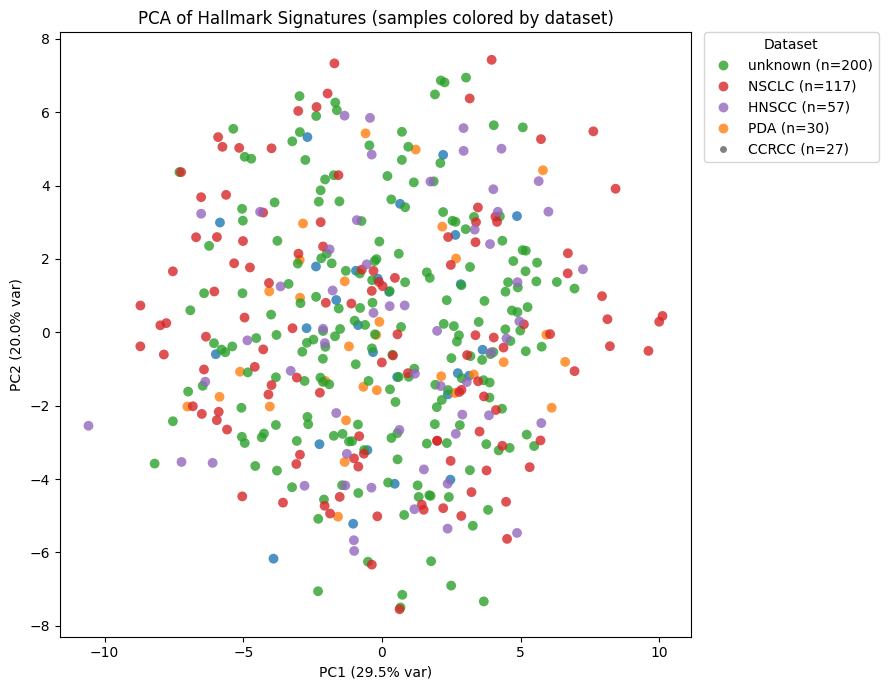

In [13]:
# PCA of genomics signatures colored by dataset/cancertype
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Paths (adjust if your files are in different locations)
combined_path = '/Users/jackie-mac/Desktop/VSCode/projects/Radiogenomics/data/procdata/gene_signatures/combined/hallmarks_all_cohorts_combined.csv'
dataset_pattern = '/Users/jackie-mac/Desktop/VSCode/projects/Radiogenomics/data/procdata/gene_signatures/**/*_hallmark_signatures.csv'  # recursive search
out_dir_pca = '/Users/jackie-mac/Desktop/VSCode/projects/Radiogenomics/data/procdata/gene_signatures/combined/plots/hallmarks_pca_by_dataset'
os.makedirs(out_dir_pca, exist_ok=True)

# Load combined signatures matrix
if not os.path.exists(combined_path):
    raise FileNotFoundError(f'Combined hallmarks file not found at {combined_path}')

combined = pd.read_csv(combined_path, index_col=0)
# Ensure numeric signature columns only
combined = combined.apply(pd.to_numeric, errors='coerce')
combined = combined.dropna(axis=1, how='all')
combined = combined.dropna(axis=0, how='all')

print(f'Loaded combined hallmarks matrix: {combined.shape[0]} samples x {combined.shape[1]} signatures')

# Map samples to datasets by scanning dataset-specific matrices
dataset_files = sorted(glob.glob(dataset_pattern, recursive=True))
if len(dataset_files) == 0:
    # try alternate pattern (plural 'hallmarks')
    dataset_pattern2 = 'data/procdata/gene_signatures/**/*_hallmarks_signatures.csv'
    dataset_files = sorted(glob.glob(dataset_pattern2, recursive=True))

sample_to_dataset = {}
for path in dataset_files:
    # dataset name derived from filename (strip suffix)
    base = os.path.splitext(os.path.basename(path))[0]
    # try to extract dataset prefix before first underscore
    dataset_name = base.split('_')[0]
    try:
        df = pd.read_csv(path, index_col=0)
    except Exception:
        # try without index
        try:
            df = pd.read_csv(path)
            if df.shape[1] > 0:
                maybe_idx = df.columns[0]
                df = df.set_index(maybe_idx)
        except Exception:
            continue
    # record mapping for samples in this dataset (if sample appears in multiple, keep first)
    for s in df.index.astype(str):
        if s not in sample_to_dataset:
            sample_to_dataset[s] = dataset_name

print(f'Found {len(dataset_files)} dataset-specific signature files; mapped {len(sample_to_dataset)} sample IDs to datasets')

# Build DataFrame for PCA containing only samples present in combined
combined_samples = combined.index.astype(str).tolist()
labels = [sample_to_dataset.get(s, 'unknown') for s in combined_samples]

pca_df = combined.copy()
# Optionally drop rows with too many NaNs
pca_df = pca_df.dropna(axis=0, thresh=max(1, int(0.5 * pca_df.shape[1])))
# align labels after dropping
aligned_samples = pca_df.index.astype(str).tolist()
labels = [sample_to_dataset.get(s, 'unknown') for s in aligned_samples]

# scaling + PCA
scaler = StandardScaler()
X = scaler.fit_transform(pca_df.values)

pca = PCA(n_components=2)
pcs = pca.fit_transform(X)
explained = pca.explained_variance_ratio_ * 100

plot_df = pd.DataFrame({
    'PC1': pcs[:, 0],
    'PC2': pcs[:, 1],
    'dataset': labels,
    'sample': aligned_samples,
})

# Plot
plt.figure(figsize=(9, 7))
ax = sns.scatterplot(
    data=plot_df,
    x='PC1', y='PC2', hue='dataset',
    palette='tab10', s=50, alpha=0.8, edgecolor='none'
)
ax.set_xlabel(f'PC1 ({explained[0]:.1f}% var)')
ax.set_ylabel(f'PC2 ({explained[1]:.1f}% var)')
ax.set_title('PCA of Hallmark Signatures (samples colored by dataset)')
# Improve legend: use dataset names and counts
handles, labels_legend = ax.get_legend_handles_labels()
# seaborn may include a title in legend; rebuild legend mapping
legend_entries = plot_df['dataset'].value_counts().sort_values(ascending=False)
legend_labels = [f'{name} (n={count})' for name, count in legend_entries.items()]
# create a legend with unique dataset handles
unique = plot_df['dataset'].unique()
# create mapping from dataset to handle
hmap = {lab: h for lab, h in zip(labels_legend[1:], handles[1:])} if len(handles) > 1 else {}
# remove existing legend and set a new one
if ax.get_legend() is not None:
    ax.get_legend().remove()
legend_handles = [hmap.get(ds, plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=6)) for ds in legend_entries.index]
ax.legend(legend_handles, legend_labels, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0., title='Dataset')

plt.tight_layout()
out_png = os.path.join(out_dir_pca, 'hallmarks_pca_by_dataset.png')
plt.savefig(out_png, dpi=200, bbox_inches='tight')
try:
    plt.savefig(out_png.replace('.png', '.pdf'), bbox_inches='tight')
except Exception:
    pass

print('Saved PCA plot to', out_png)

# Also save the PCA coordinates with dataset labels for downstream use
coords_out = os.path.join(out_dir_pca, 'hallmarks_pca_coordinates.csv')
plot_df.to_csv(coords_out, index=False)
print('Saved PCA coordinates to', coords_out)
